# Central Bank Communication & Information Overload
**Goal**: Build a Communication Intensity Index (CII) from Fed speeches and study its (non-linear) impact on market volatility and reactions.

**Pipeline overview**
1. Data → speeches (Fed) & markets (VIX, SPX, TNX, DXY, EURUSD)
2. NLP → tone (FinBERT), lexical/semantic features, weekly aggregation
3. CII → combine quantity, dispersion, tone & redundancy
4. Models → OLS baselines, RF/XGBoost, GAM; interpretation (PDP/SHAP)
5. Robustness → subsamples (calm vs crisis), lags, Granger tests


In [ ]:
#!pip install yfinance --quiet

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


#### Step 1: Descriptive exploration of speeches

Goal: understand the structure and dynamics of the corpus.

→ Purpose: before doing any NLP, identify who speaks, when, how often, at what pace, and under what conditions.

Distribution of word count by year and by speaker,
Evolution of the number of speeches over time,
Correlation between length and frequency,
Number of active speakers per month

Yearly summary:
       n_speeches       avg_wc  n_speakers
year                                     
2021          68  2322.838235           8
2022          45  2188.088889           9
2023          95  2090.768421           8
2024         104  2498.903846           8
2025         100  2356.920000          12

Top speakers:
                                 n_speeches       avg_wc
speaker                                                
Governor Michelle W. Bowman            116  2503.068966
Governor Lael Brainard                  99  2710.101010
Governor Christopher J. Waller          70  2402.842857
Chair Jerome H. Powell                  61  1458.704918
Chairman Ben S. Bernanke                52  2703.192308
Governor Jerome H. Powell               50  2351.700000
Vice Chairman Stanley Fischer           45  2913.644444
Chair Janet L. Yellen                   44  2737.136364
Governor Lisa D. Cook                   42  2050.095238
Governor Daniel K. Tarullo              39  4497.051282


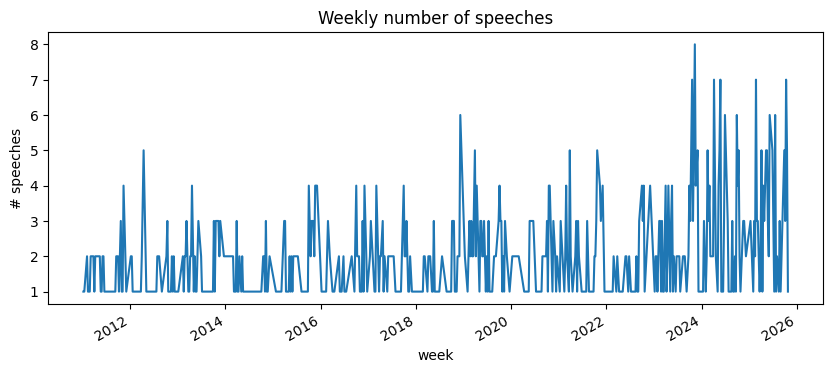

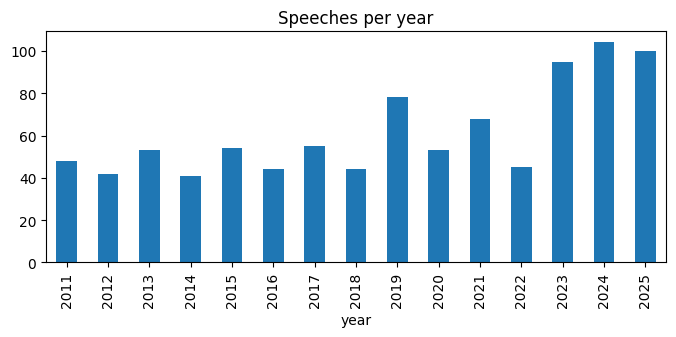


Correlation (# speeches vs avg length): -0.03


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load speeches
speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")
speeches = speeches.drop_duplicates(subset=["url", "date", "speaker"])
speeches = speeches[speeches["word_count"] > 20].reset_index(drop=True)
speeches["year"] = speeches["date"].dt.year
speeches["month"] = speeches["date"].dt.to_period("M").dt.to_timestamp("M")
speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

# Basic yearly and speaker stats
by_year = speeches.groupby("year").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)
by_speaker = speeches.groupby("speaker").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean")
).sort_values("n_speeches", ascending=False).head(10)

print("Yearly summary:\n", by_year.tail())
print("\nTop speakers:\n", by_speaker)

# Weekly and monthly cadence
weekly = speeches.groupby("week").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)

monthly = speeches.groupby("month").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)

# 3) Quick plots
weekly["n_speeches"].plot(figsize=(10,4), title="Weekly number of speeches", ylabel="# speeches")
plt.show()

by_year["n_speeches"].plot(kind="bar", figsize=(8,3), title="Speeches per year")
plt.show()

# 4) Correlation: are busy weeks longer on average?
corr = weekly["n_speeches"].corr(weekly["avg_wc"])
print(f"\nCorrelation (# speeches vs avg length): {corr:.2f}")

The correlation between the number of speeches per week and their average length is slightly negative (–0.03).
This indicates that when the Fed communicates more frequently, speeches are not necessarily longer and may even be slightly shorter.

####Step 2 — Lexical and Tonal Analysis*

Goal: Extract the main lexical fields, tone, and semantic redundancies in Fed speeches.
This section cleans and tokenizes the texts, identifies the most frequent and discriminant words (via TF-IDF), and groups speeches into semantic clusters using sentence embeddings (SBERT) and K-Means/UMAP.

Finally, it analyzes the tone (FinBERT or VADER) across themes, speakers, and time periods — revealing which topics are more positive, negative, or neutral, and how the Fed’s communication focus shifts during market stress (e.g., inflation, policy stance, financial stability).

In [9]:
import pandas as pd, re, nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')

speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")
speeches = speeches.dropna(subset=["text"]).copy()
speeches = speeches[speeches["text"].str.len() > 30].reset_index(drop=True)

STOPWORDS = set(stopwords.words("english"))                                     # Convert everything to lowercase (case-insensitive analysis)
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r"[^a-z\s]", " ", txt)                                         # Remove punctuation, numbers, and symbols
    return [w for w in txt.split() if w not in STOPWORDS and len(w) > 2]        # Split text into individual words (“tokens”), remove useless common words (“the”, “and”, “of”…) and remove ultra-short tokens like “a”, “us”, “it”

speeches["tokens"] = speeches["text"].apply(clean_text)
speeches["year"] = speeches["date"].dt.year

# Top frequent words per year : here, we group all speeches from the same year, merge all their tokens and find the most common words 
def top_words_by_year(df, n=10):
    return (
        df.groupby("year")["tokens"]
          .apply(lambda x: Counter([w for tokens in x for w in tokens]).most_common(n))
    )

top_words = top_words_by_year(speeches, n=15)
print(top_words.head())

# Quick global word frequency: this merges all speeches together, giving the 30 most frequent words in the full dataset:
all_words = [w for tokens in speeches["tokens"] for w in tokens]
freq = Counter(all_words).most_common(30)
pd.DataFrame(freq, columns=["word", "count"]).head(10)

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


year
2011    [(financial, 1275), (federal, 577), (economic,...
2012    [(financial, 877), (banks, 727), (federal, 671...
2013    [(financial, 1142), (federal, 709), (policy, 6...
2014    [(financial, 935), (policy, 550), (banks, 536)...
2015    [(financial, 1022), (policy, 697), (inflation,...
Name: tokens, dtype: object


,word,count
0,financial,12594
1,policy,10922
2,inflation,10427
3,banks,9094
4,federal,8708
5,market,7501
6,rate,7162
7,bank,6802
8,percent,6617
9,reserve,6436


##### EXPLICATION CODE PRECEDANT 

Il lit notre fichier fed_speeches.csv contenant tous les discours (date, speaker, texte, word_count…).

Il nettoie le texte : met tout en minuscules, supprime la ponctuation, les chiffres et les mots vides (“the”, “and”, “of”…), garde uniquement les mots de plus de 2 lettres.
Il crée une nouvelle colonne tokens contenant les mots utiles pour chaque discours.

Il ajoute une colonne year pour faciliter les regroupements par année.

Ensuite la fonction top_words_by_year : pour chaque année, on tous les discours et compte les mots les plus fréquents.
→ On peut voir l’évolution du vocabulaire : par exemple “inflation” dominait en 2018-19, “pandemic” en 2020, “policy” ou “rates” ensuite.

Top words : comptage sur l’ensemble des années pour connaître le vocabulaire central de la Fed.

But : repérer les grandes tendances lexicales avant toute modélisation pour voir apparaître les thématiques principales et leur évolution temporelle.

2.1 TF-IDF — Top discriminative terms (by year / by speaker)
What it does: build a TF-IDF matrix on cleaned speeches, then for each group (year or speaker), average TF-IDF scores and list the top terms.

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

speeches = speeches.copy()
speeches["year"] = speeches["date"].dt.year

# Build TF-IDF (1-2 grams, light pruning)
vectorizer = TfidfVectorizer(
    lowercase=True, stop_words="english",
    ngram_range=(1,2), min_df=5, max_df=0.9
)
X = vectorizer.fit_transform(speeches["text"].fillna(""))
terms = np.array(vectorizer.get_feature_names_out())

def top_tfidf_for_groups(group_col, topk=15, min_group_size=5):
    out = {}
    for g, idx in speeches.groupby(group_col).indices.items():
        if len(idx) < min_group_size: 
            continue
        avg = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = np.argsort(avg)[::-1][:topk]
        out[g] = list(zip(terms[top_idx], avg[top_idx]))
    return out

top_by_year = top_tfidf_for_groups("year", topk=15, min_group_size=5)
top_by_speaker = top_tfidf_for_groups("speaker", topk=15, min_group_size=5)

# Display top discriminant terms per year (clean output)
for year, words in top_by_year.items():
    print(f"\n{year}")
    print(", ".join([w for w, _ in words]))


2011
financial, capital, economic, policy, crisis, term, market, recovery, fiscal, federal reserve, firms, credit, rates, economies, monetary

2012
banks, financial, community, mortgage, policy, term, market, federal reserve, housing, community banks, recovery, economic, lending, banking, crisis

2013
financial, capital, policy, banks, market, term, crisis, federal reserve, risk, bank, asset, community, monetary, economic, rate

2014
financial, policy, banks, community, risk, monetary, capital, crisis, market, monetary policy, firms, community banks, bank, federal reserve, rate

2015
financial, inflation, policy, market, rate, banks, monetary, crisis, liquidity, monetary policy, capital, institutions, community, percent, markets

2016
rate, inflation, financial, growth, policy, percent, productivity, market, monetary, labor, monetary policy, rates, economic, capital, economy

2017
policy, rate, inflation, financial, monetary, monetary policy, rates, market, banks, economic, federal re

In [ ]:
# Display top discriminant terms per speaker
for spk, words in list(top_by_speaker.items())[:5]:  # les 5 premiers pour éviter trop de texte
    print(f"\n{spk}")
    print(", ".join([w for w, _ in words]))


🎤 Chair Janet L. Yellen
inflation, rate, policy, financial, labor, economic, monetary, monetary policy, economy, percent, funds rate, fomc, market, community, women

🎤 Chair Jerome H. Powell
inflation, policy, percent, economy, monetary, labor, monetary policy, economic, pandemic, fed, market, growth, labor market, rate, time

🎤 Chairman Ben S. Bernanke
financial, economic, federal reserve, banks, policy, term, community, crisis, monetary, fiscal, market, recovery, rates, economy, capital

🎤 Chairman Jerome H. Powell
inflation, financial, unemployment, policy, economy, rural, rate, monetary, labor, communities, monetary policy, fed, community, growth, crisis

🎤 Governor Adriana D. Kugler
inflation, labor, phillips, phillips curve, pandemic, percent, curve, curve model, kugler, supply, policy, workers, goods, inflation dynamics, prices


##### EXPLICATION CODE PRECEDANT 

On transforme tous les textes en une matrice TF-IDF (Term Frequency – Inverse Document Frequency).
Cette méthode donne plus de poids aux mots typiques d’un texte, et moins à ceux qu’on retrouve partout.
On obtient une matrice X où chaque ligne = un discours, chaque colonne = un mot et chaque cellule = importance du mot dans ce discours.

Ensuite on calcule la moyenne des scores TF-IDF par année et par orateur et extrait les top 15 mots les plus représentatifs de chacun.

Exemples de lecture :
En 2020, les mots TF-IDF les plus discriminants pourraient être “pandemic”, “support”, “recovery”.
Pour Jerome Powell, on pourrait retrouver “policy”, “rate”, “inflation”.
Pour Lael Brainard, davantage “climate”, “inclusion”, “digital”.

But : identifier les mots qui définissent le style ou la période d’un discours, pas seulement les plus fréquents.

2.3 Semantic themes — Embeddings + K-Means (and optional UMAP coords)
What it does: create sentence embeddings for each speech, cluster them into themes, label each speech with a cluster, and compute top TF-IDF terms per cluster to interpret themes.

In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

texts = speeches["text"].fillna("").tolist()

# rebuild TF-IDF if needed
if "X" not in locals() or "terms" not in locals():
    vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",
                                 ngram_range=(1,2), min_df=5, max_df=0.9)
    X = vectorizer.fit_transform(texts)
    terms = np.array(vectorizer.get_feature_names_out())

model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

K = 6
km = KMeans(n_clusters=K, n_init=10, random_state=42)
speeches["theme_cluster"] = km.fit_predict(emb)

def top_terms_for_cluster(cluster_id, topk=20):
    idx = speeches.index[speeches["theme_cluster"] == cluster_id].tolist()
    if not idx: return []
    avg = np.asarray(X[idx].mean(axis=0)).ravel()
    top_idx = np.argsort(avg)[::-1][:topk]
    return list(zip(terms[top_idx], avg[top_idx]))

cluster_terms = {c: top_terms_for_cluster(c, topk=20) for c in range(K)}
cluster_terms

# optional UMAP coords
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    coords_2d = reducer.fit_transform(emb)
    speeches["umap_x"] = coords_2d[:,0]
    speeches["umap_y"] = coords_2d[:,1]
except Exception:
    pass

Batches: 100%|██████████| 30/30 [06:32<00:00, 13.08s/it]
/opt/python/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



🔹 Étape 3 : Identification des thèmes et répétitions
Objectif : regrouper les discours par “contenu” plutôt que par date.
→ Là, tu regardes si certains thèmes réapparaissent trop souvent
et si leur “intensité de répétition” provoque une fatigue de marché.
✅ Méthode possible :
Utiliser les embeddings SBERT (tu as déjà la base pour ça) pour calculer la similarité cosinus entre tous les discours.
Regrouper par clusters thématiques (k-means ou HDBSCAN) ;
Calculer un “communication saturation index” = combien de discours similaires sont faits dans la même semaine / mois.
🧠 Hypothèse :
Trop de discours similaires (répétition) → la réaction marginale du marché diminue.

🔹 Étape 4 : Analyse des mots / expressions “influentes”
Objectif : tester si certains mots ou expressions sont associés à des réactions de marché.
→ Pour chaque mot, on peut regarder :
la variation moyenne du marché (ΔVIX, ΔSPX) dans les 1-3 jours suivant un discours contenant ce mot ;
ou la corrélation entre la fréquence de ce mot et la volatilité.
Techniquement : on peut faire ça avec un simple CountVectorizer puis des régressions ou corrélations mot-par-mot.
💭 Tu peux aussi aller plus loin :
entraînement d’un petit modèle (logit ou arbre) où la variable cible est “réaction positive/négative du marché”.
🔹 Étape 5 : Fusion avec données de marché (phase 2)
Objectif : mesurer les réactions de marché à court terme (1-3 jours)
→ Une fois les discours scorés (thème, ton, intensité, redondance…), tu les merges sur la date pour mesurer :
ΔSPX, ΔVIX, ΔTNX, ΔDXY sur 1, 2, 3 jours après chaque discours ;
puis tu fais :
régressions linéaires / GAM ;
Random Forest ou XGBoost pour capturer la non-linéarité ;
visualisation (SHAP, PDP) pour interpréter les effets.

Étape	Description	Lien avec CII 
1️⃣	Exploration descriptive : fréquence, speakers, longueur	→ Base quantitative du CII (# speeches, # speakers, mean word count)
2️⃣	Tonal & lexical analysis (FinBERT + lexique)	→ Base tonale du CII (avg tone, tone dispersion)
3️⃣	Clustering thématique & redondance	→ Base sémantique du CII (semantic overlap, redundancy, “repeated topics”)
4️⃣	Aggregation weekly	→ Tout regrouper au niveau hebdomadaire (pour comparer à VIX, SPX, etc.)
5️⃣	Construction du CII	→ Pondérer et combiner les dimensions normalisées
6️⃣	Link to markets	→ Étudier comment CII prédit ou influence la réaction des marchés